# Playing with HCP Dataset

In this notebook, I do some analysis on the NMA-preprocessed HCP dataset.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Dataset Information

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [2]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

subjects = np.loadtxt('subjects_list.txt', dtype='str')

# Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)

# Region information

In [3]:
regions = np.load(f"regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Helper Functions

In [4]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [5]:
import sys
np.set_printoptions(threshold=sys.maxsize)
regions

array([['R_V1', 'R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_4',
        'R_3b', 'R_FEF', 'R_PEF', 'R_55b', 'R_V3A', 'R_RSC', 'R_POS2',
        'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT',
        'R_MT', 'R_A1', 'R_PSL', 'R_SFL', 'R_PCV', 'R_STV', 'R_7Pm',
        'R_7m', 'R_POS1', 'R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv',
        'R_5m', 'R_5mv', 'R_23c', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL',
        'R_SCEF', 'R_6ma', 'R_7Am', 'R_7PL', 'R_7PC', 'R_LIPv', 'R_VIP',
        'R_MIP', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v',
        'R_p24pr', 'R_33pr', 'R_a24pr', 'R_p32pr', 'R_a24', 'R_d32',
        'R_8BM', 'R_p32', 'R_10r', 'R_47m', 'R_8Av', 'R_8Ad', 'R_9m',
        'R_8BL', 'R_9p', 'R_10d', 'R_8C', 'R_44', 'R_45', 'R_47l',
        'R_a47r', 'R_6r', 'R_IFJa', 'R_IFJp', 'R_IFSp', 'R_IFSa',
        'R_p9-46v', 'R_46', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v',
        'R_a10p', 'R_10pp', 'R_11l', 'R_13l', 'R_OFC', 'R_47s', 'R_LIPd',
        'R_6a', 'R_i6-8', 'R

# Working Memory (WM) Analysis

### Single Subject

In [6]:
exp = 'WM'
subj = subjects[1]
run = 1

data = load_single_timeseries(subject=subj,
                              experiment=exp,
                              run=run,
                              remove_mean=True)
print('Data shape: ', data.shape)

evs = load_evs(subject=subj, experiment=exp, run=run)

Data shape:  (360, 405)


# FFC Signals for Face Conditions

## Single Subject

In [7]:
# Get the data for FFC area
r_ffc_indices = np.where(regions[0] == 'R_FFC')[0]
l_ffc_indices = np.where(regions[0] == 'L_FFC')[0]
ffc_indices = np.concatenate((r_ffc_indices, l_ffc_indices))
ffc_data = data[ffc_indices, :]

In [8]:
faces_2bk_idx = EXPERIMENTS[exp]['cond'].index('2bk_faces')
faces_0bk_idx = EXPERIMENTS[exp]['cond'].index('0bk_faces')

In [9]:
data_2bk_face = ffc_data[:, evs[faces_2bk_idx]]
data_0bk_face = ffc_data[:, evs[faces_0bk_idx]]

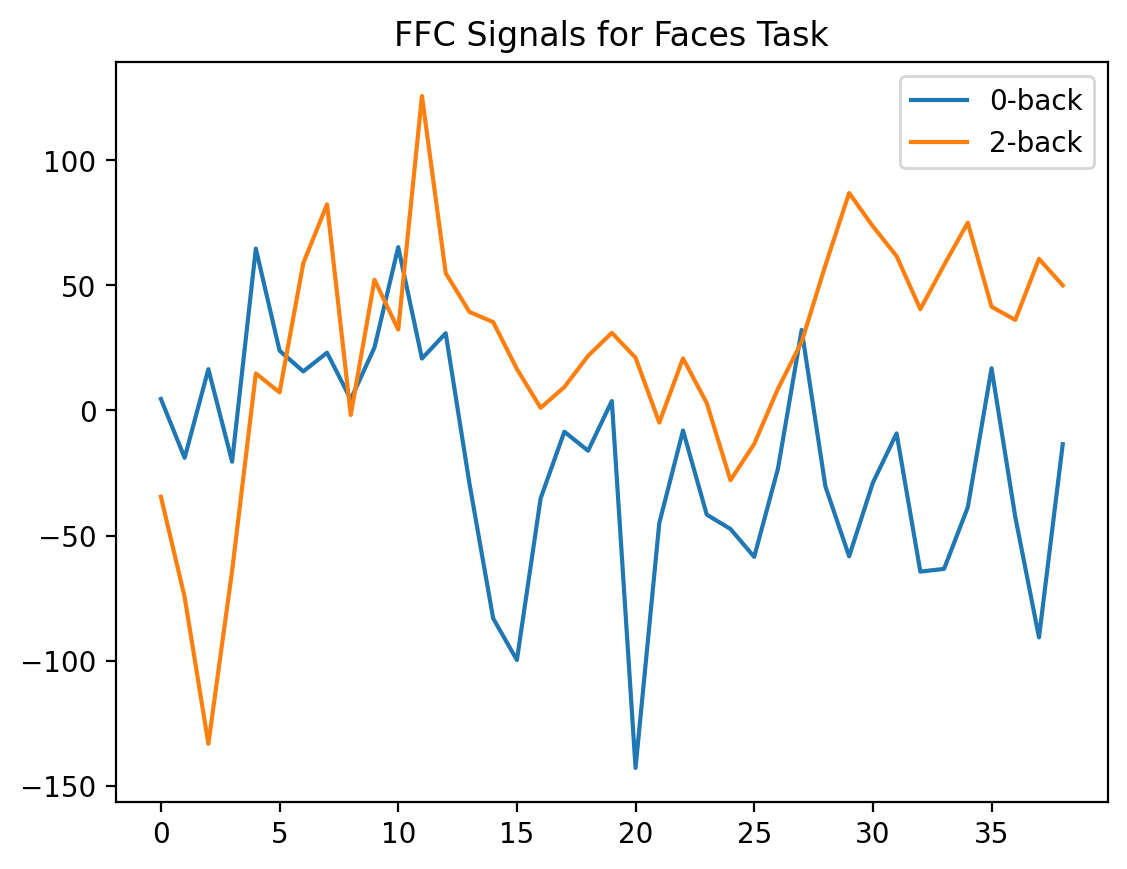

In [10]:
plt.plot(data_0bk_face.mean(axis=0)[0,:], label='0-back')
plt.plot(data_2bk_face.mean(axis=0)[0,:], label='2-back')
plt.title('FFC Signals for Faces Task')
plt.legend()
plt.show()

## Group Analysis

In [13]:
my_exp = 'WM'
other_area = '2bk_tools' # To compare

def get_ffc_data(data):
  r_ffc_idx = np.where(regions[0] == 'R_FFC')[0] # Right and left FFC are defined separately in regions variable
  l_ffc_idx = np.where(regions[0] == 'L_FFC')[0]
  ffc_idx = np.concatenate((r_ffc_idx, l_ffc_idx)) # Concatenate FFC area signals for left and right
  ffc_data = data[ffc_idx, :] # Take only parcels for FFC from original data, note that we take whole timepoints
  return ffc_data

# SELECT INDICES FROM NECESSARY TASKS
faces_2bk_idx = EXPERIMENTS[exp]['cond'].index('2bk_faces') # Take condition specific indices
faces_0bk_idx = EXPERIMENTS[exp]['cond'].index('0bk_faces')
other_area_idx = EXPERIMENTS[exp]['cond'].index(other_area)

def get_cond_related_signal(data, evs, idx):
  return data[:, evs[idx]]

"""data_2bk = ffc_data[:, evs[faces_2bk_idx]] # Take only the condition from the ffc_data
data_0bk = ffc_data[:, evs[faces_0bk_idx]]
data_other = ffc_data[:, evs[other_area_idx]]"""

faces_2bk_all, faces_0bk_all, other_all = [], [], []
for i in range(len(subjects)):
  # Get subject specific data ==========
  my_subj = subjects[i]
  my_run = 1

  data = load_single_timeseries(subject=my_subj,
                                experiment=exp,
                                run=my_run,
                                remove_mean=True)
  evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
  # ==========
  ffc_data = get_ffc_data(data) # Get FFC data for a subject

  faces_2bk_all.append(get_cond_related_signal(ffc_data, evs, faces_2bk_idx))
  faces_0bk_all.append(get_cond_related_signal(ffc_data, evs, faces_0bk_idx))
  other_all.append(get_cond_related_signal(ffc_data, evs, other_area_idx))

# Turn them into np arrays for easier manipulation
faces_2bk_all = np.array(faces_2bk_all)
faces_0bk_all = np.array(faces_0bk_all)
other_all = np.array(other_all)

# We take mean twice, first one for across subjects, second one for left-right, resulting shape is 39,
mean_all_faces_2bk = faces_2bk_all.mean(axis=0).mean(axis=0)[0,:]
mean_all_faces_0bk = faces_0bk_all.mean(axis=0).mean(axis=0)[0,:]
mean_all_other = other_all.mean(axis=0).mean(axis=0)[0,:]

In [14]:
len(mean_all_faces_2bk) * 0.72 # About 28 s total task

28.08

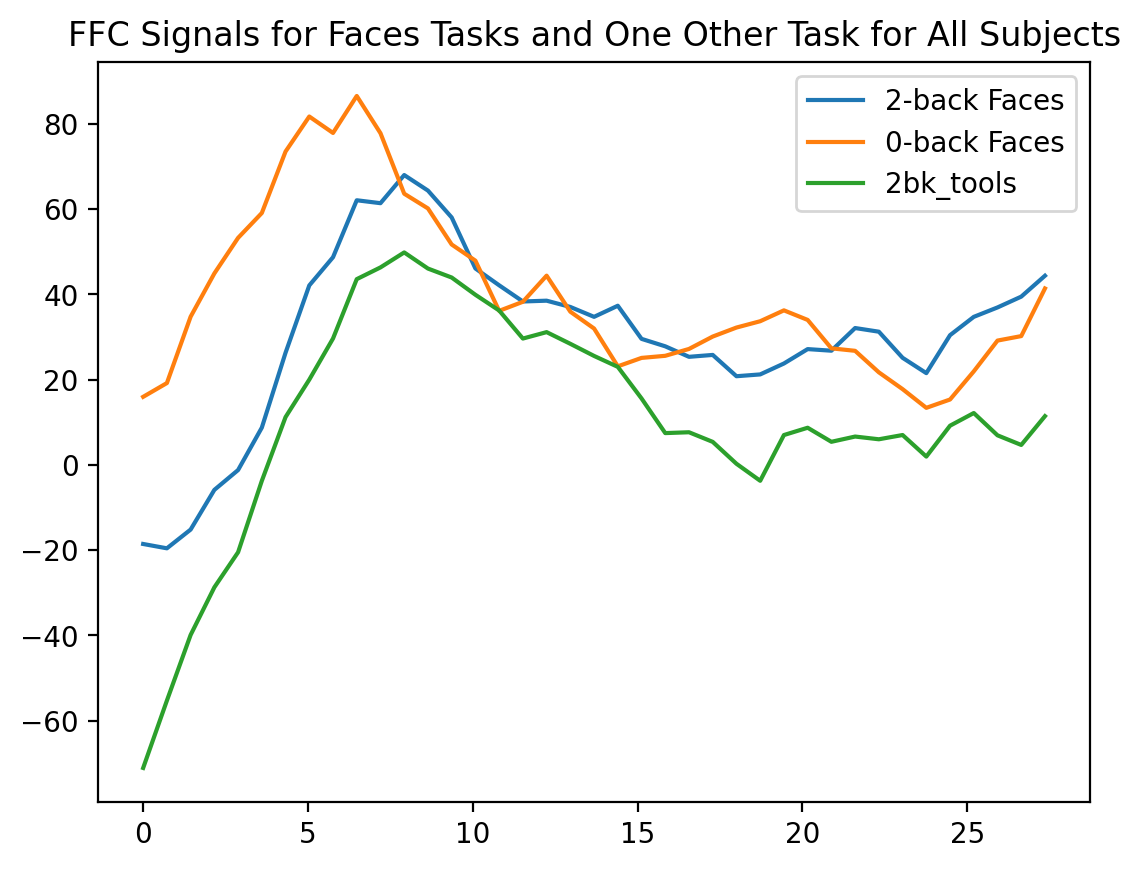

In [15]:
plt.plot(np.array(range(len(mean_all_faces_2bk)))*0.72, mean_all_faces_2bk, label='2-back Faces')
plt.plot(np.array(range(len(mean_all_faces_2bk)))*0.72, mean_all_faces_0bk, label='0-back Faces')
plt.plot(np.array(range(len(mean_all_faces_2bk)))*0.72, mean_all_other, label=other_area)
plt.title('FFC Signals for Faces Tasks and One Other Task for All Subjects')
plt.legend()
plt.show()

## Contrast

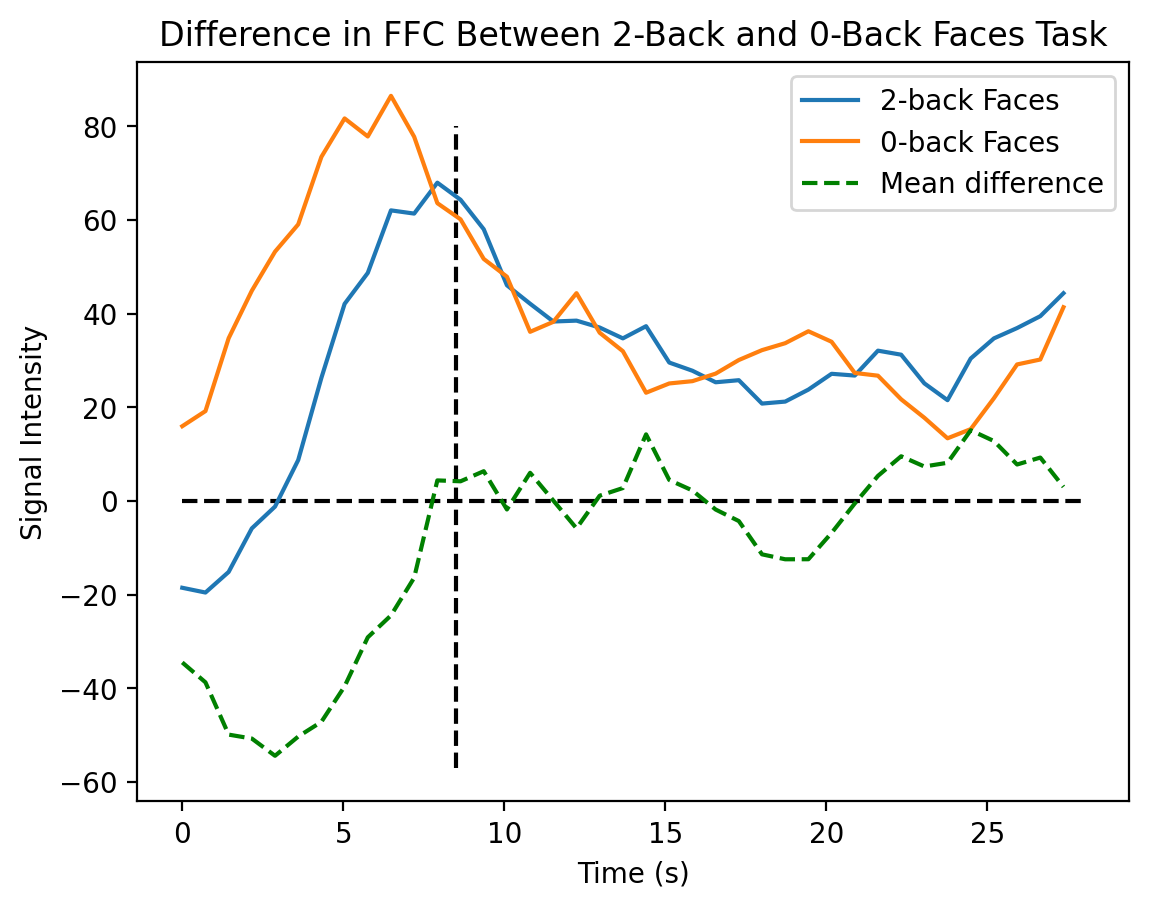

In [16]:
diff = mean_all_faces_2bk - mean_all_faces_0bk

secs = np.array(range(len(mean_all_faces_2bk)))*0.72

plt.plot([0,28], [0,0], 'k--')
plt.plot([8.5,8.5], [-57,80], 'k--')
plt.plot(secs, mean_all_faces_2bk, label='2-back Faces')
plt.plot(secs, mean_all_faces_0bk, label='0-back Faces')
plt.plot(secs, diff, 'g--', label = 'Mean difference')
plt.title('Difference in FFC Between 2-Back and 0-Back Faces Task')
plt.xlabel('Time (s)')
plt.ylabel('Signal Intensity')
plt.legend()
plt.show()

## Mean Difference for Other Categories with Face

In [7]:
"""
Get mean signals for a desired parcel, task and experiment.
Note that the length will be same as task lenght (for ex. 39 for WM tasks, since there are 40 timepoints)
"""

exp = 'WM'

##### HELPERS
def get_area_data(data, area):
  area_idx = np.where(regions[0] == area)[0] # Get area indices
  return data[area_idx, :] # Get that area from the data and return

def get_ev_indices(exp, cond):
  """Returns the condition indices relating to fMRI data"""
  return EXPERIMENTS[exp]['cond'].index(cond)

def get_cond_related_signal(data, evs, idx):
  return data[:, evs[idx]]

##### Return mean signal across subjects for a condition and a region
def calc_mean_signal(exp, cond, area):
  area_all = []
  for i in range(len(subjects)):
    # Get subject specific data ==========
    my_subj = subjects[i]
    my_run = 1

    data = load_single_timeseries(subject=my_subj,
                                  experiment=exp,
                                  run=my_run,
                                  remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=exp, run=my_run)
    # ==========
    area_data = get_area_data(data, area) # Get area data, note that contains all conditions
    cond_idx = get_ev_indices(exp, cond) # Get desired condition's indices
    # Get the subject condition data for desired area, append it to all subject list
    area_all.append(get_cond_related_signal(area_data, evs, cond_idx))
  # Turn them into np arrays for easier manipulation
  area_all = np.array(area_all)
  # We take mean twice, first one for across subjects, second one for left-right, resulting shape is (39,)
  return area_all.mean(axis=0).mean(axis=0)[0,:]

##### Test
calc_mean_signal(exp, '2bk_faces', 'R_FFC')

array([-15.16348645, -16.79763301, -12.80763733,  -7.8743754 ,
        -2.53225892,   9.08808549,  27.03307097,  40.4664929 ,
        50.75115505,  66.23708146,  69.23987608,  80.52642856,
        73.20864391,  60.51071621,  49.16391093,  49.65398271,
        49.91775967,  45.86878915,  42.94825354,  35.83317513,
        46.41195901,  38.3657436 ,  32.95978154,  31.80122531,
        28.91812055,  23.88174405,  25.81421946,  31.63771357,
        34.78226577,  32.52446763,  37.05365254,  38.16298602,
        28.57199372,  28.46378269,  38.73820225,  42.55988457,
        41.96683922,  53.83777841,  56.25040907])

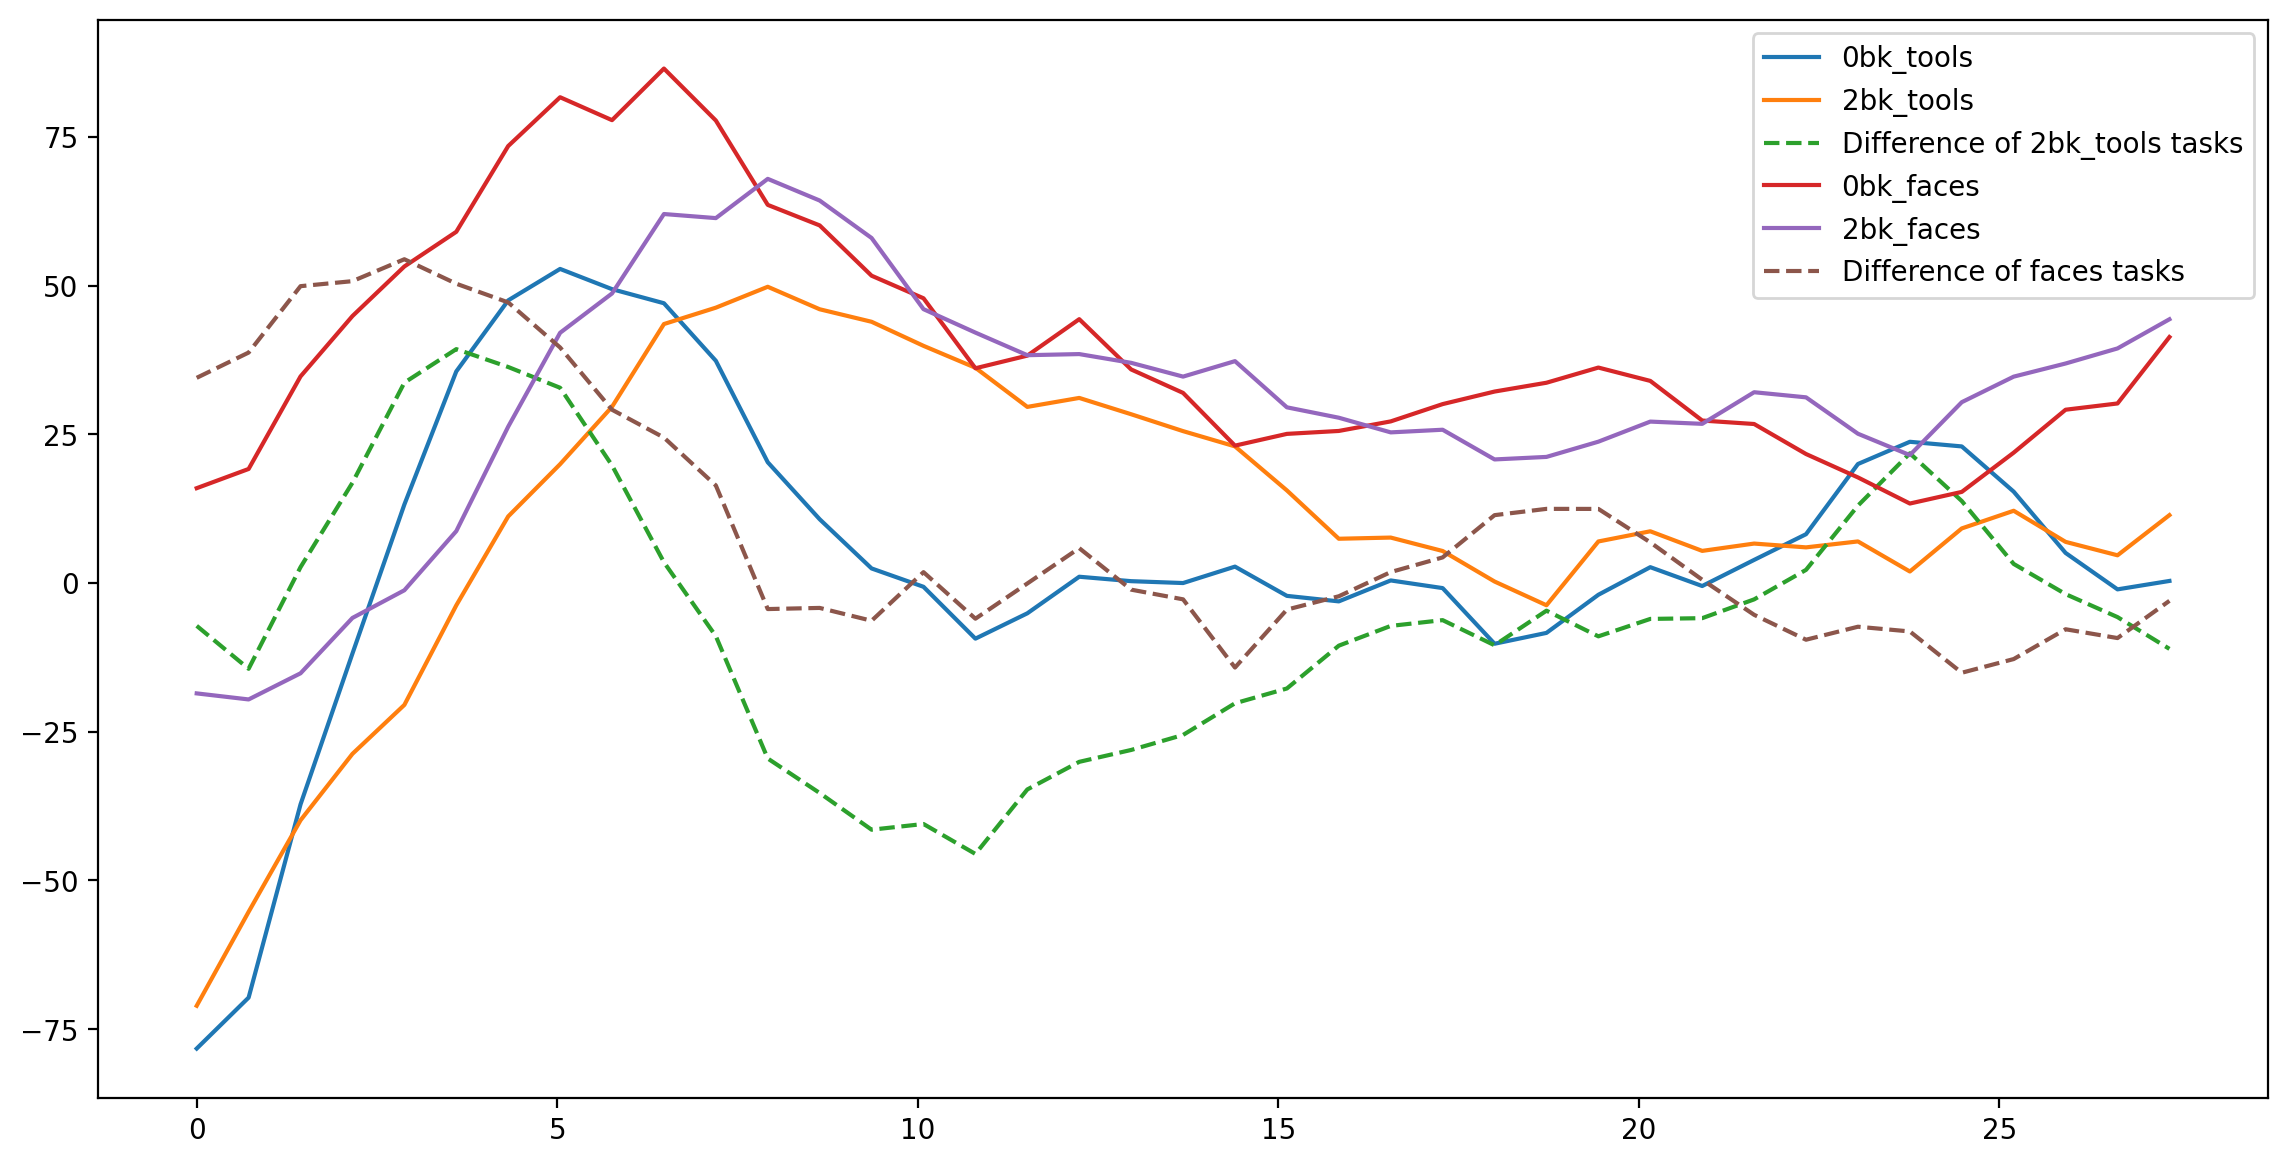

In [18]:
# Plot mean faces task difference and mean other task diff
other_task = 'tools' # Change here for choosing other tasks
desired_areas = ['R_FFC', 'L_FFC']
plot_task_mean_data = True

other_tasks = [i+other_task for i in ['0bk_', '2bk_']]
faces_tasks = ['0bk_faces', '2bk_faces']

plt.figure(figsize=(14,7))

diff_lst = []
for task in other_tasks: # For each task
  area_data = []
  for area in desired_areas: # Take mean signal separately (mean of all desired areas)
    area_data.append(calc_mean_signal(exp, task, area))
  area_data = np.array(area_data).mean(axis=0)
  if plot_task_mean_data: plt.plot(secs, area_data, label=task)
  # Difference calculation
  diff_lst.append(area_data)
plt.plot(secs, diff_lst[0]-diff_lst[1], '--', label='Difference of {} tasks'.format(task))

diff_lst = []
for task in faces_tasks: # I write a separate for loop, delete this one if you dont want to plot faces
  area_data = []
  for area in desired_areas: # Take mean signal separately (mean of all desired areas)
    area_data.append(calc_mean_signal(exp, task, area))
  area_data = np.array(area_data).mean(axis=0)
  if plot_task_mean_data: plt.plot(secs, area_data, label=task)
  # Difference calculation
  diff_lst.append(area_data)
plt.plot(secs, diff_lst[0]-diff_lst[1], '--', label='Difference of faces tasks')

plt.legend()
plt.show()

# Connectivity Map

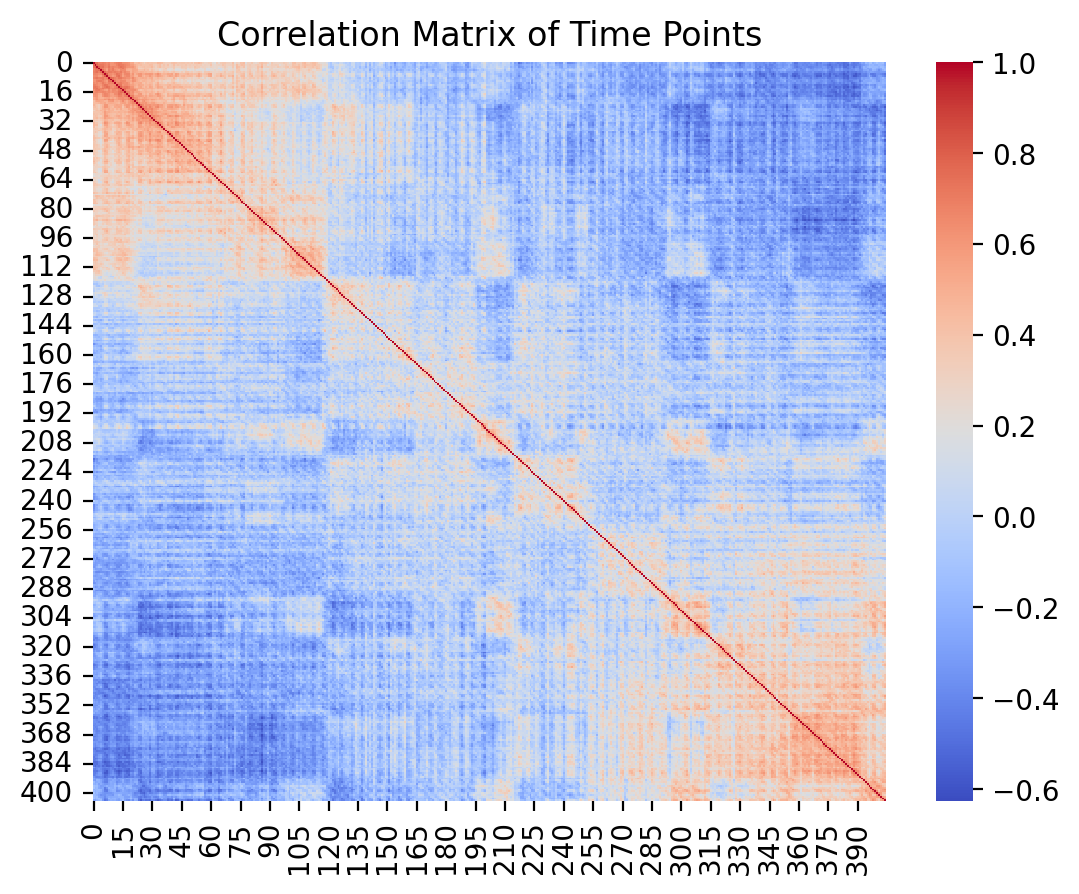

In [20]:
import seaborn as sns

corr_mat = np.corrcoef(data.T) # Whole dataset correlation across time

sns.heatmap(corr_mat, cmap='coolwarm')
plt.title('Correlation Matrix of Time Points')
plt.show()

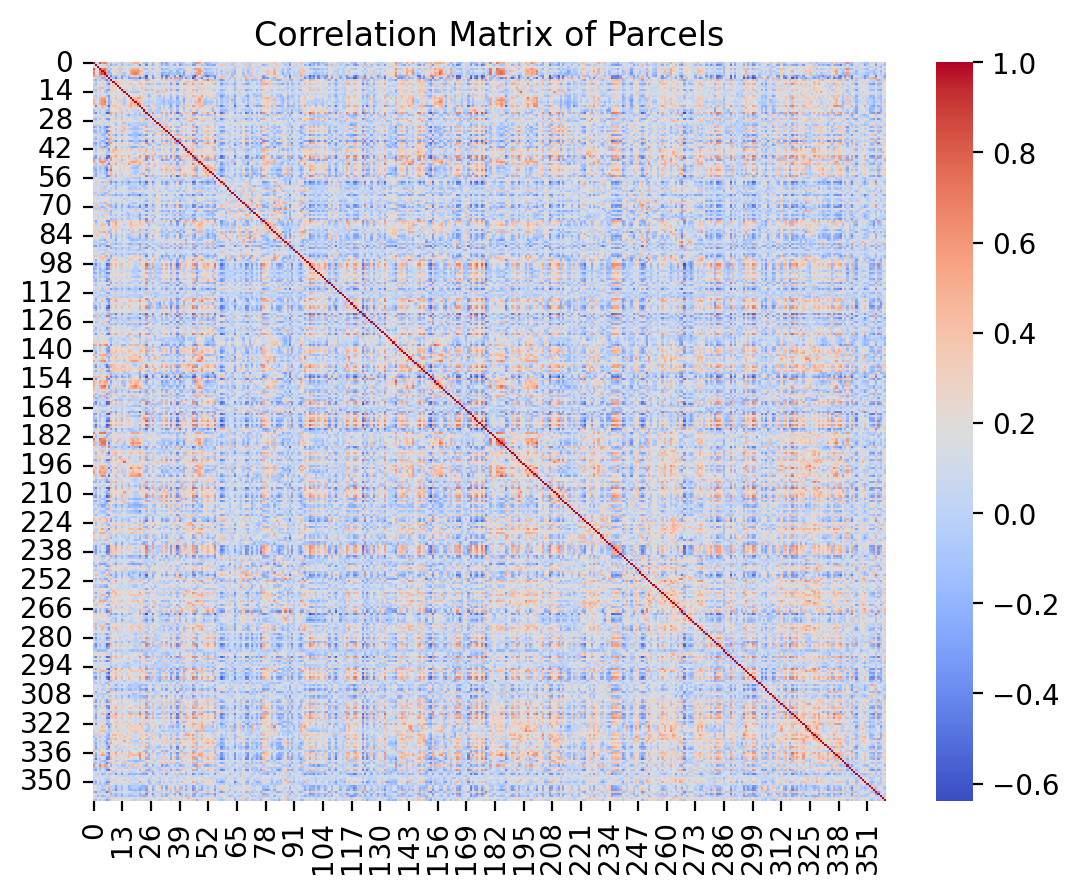

In [19]:
corr_mat = np.corrcoef(data) # Whole dataset correlation across time

sns.heatmap(corr_mat, cmap='coolwarm')
plt.title('Correlation Matrix of Parcels')
plt.show()

# ROI Activity

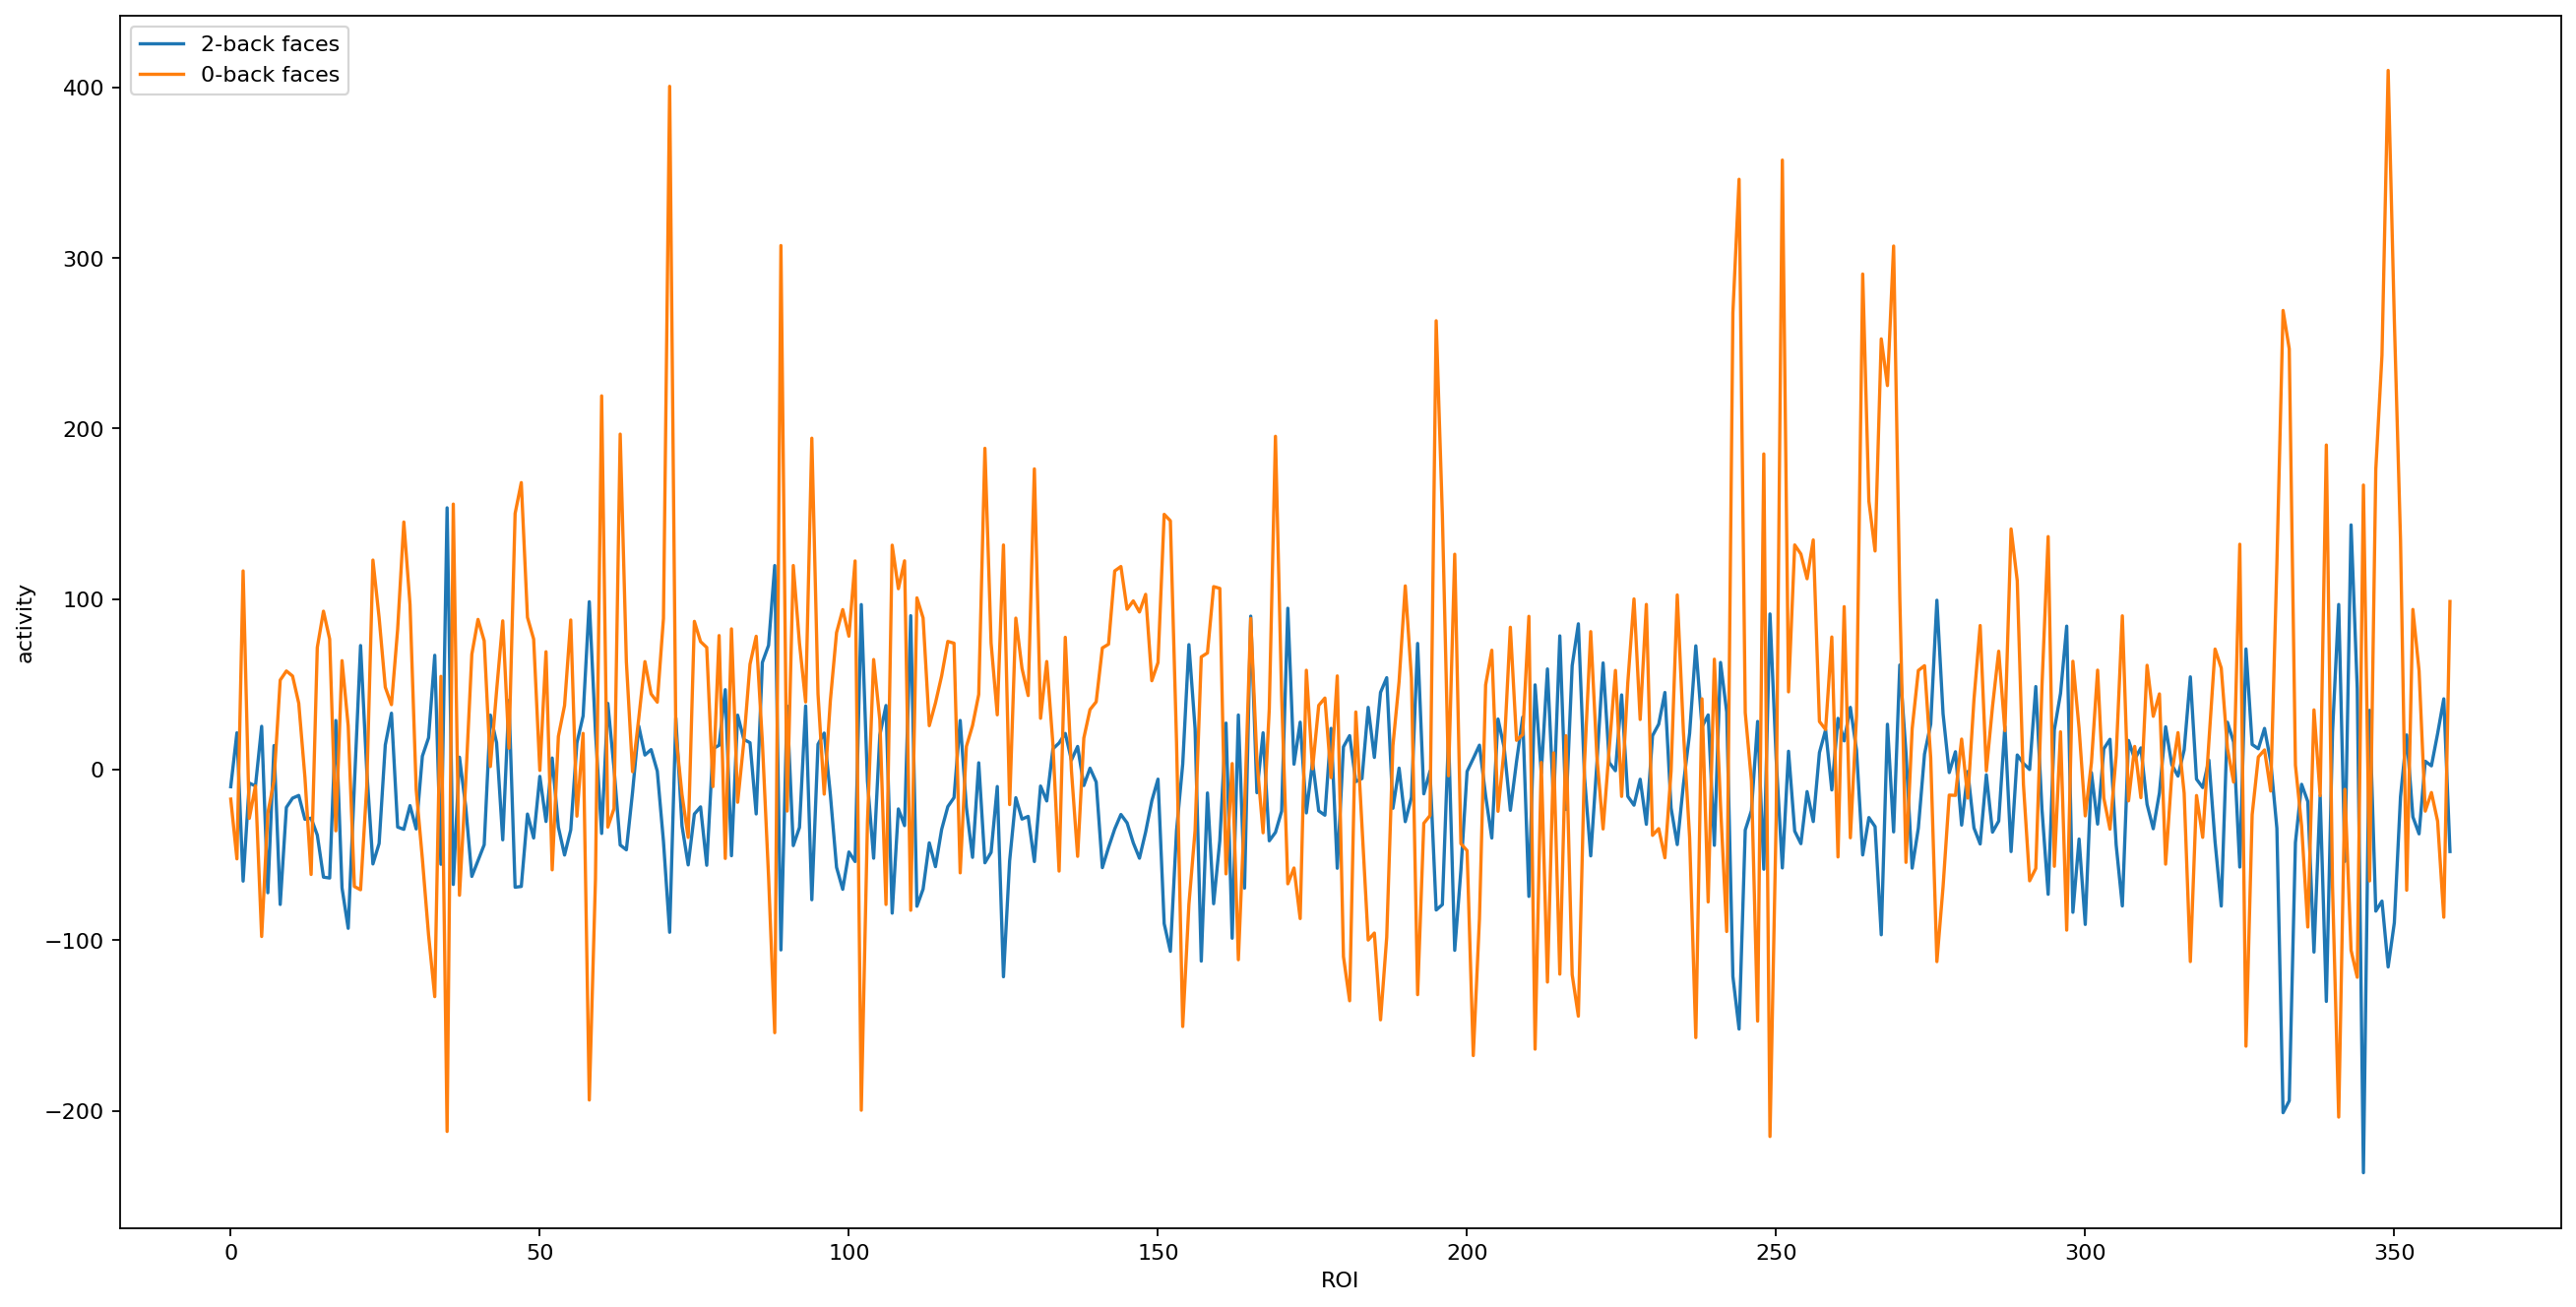

In [29]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


activity_2bk = average_frames(data, evs, exp, '2bk_faces')
activity_0bk = average_frames(data, evs, exp, '0bk_faces')
contrast = activity_2bk - activity_0bk  # difference between 2-back and 0-back for face condition

from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
# Plot activity level in each ROI for both conditions
plt.plot(activity_2bk,label='2-back faces')
plt.plot(activity_0bk,label='0-back faces')
#plt.scatter(range(360), contrast, label = 'Contrast')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

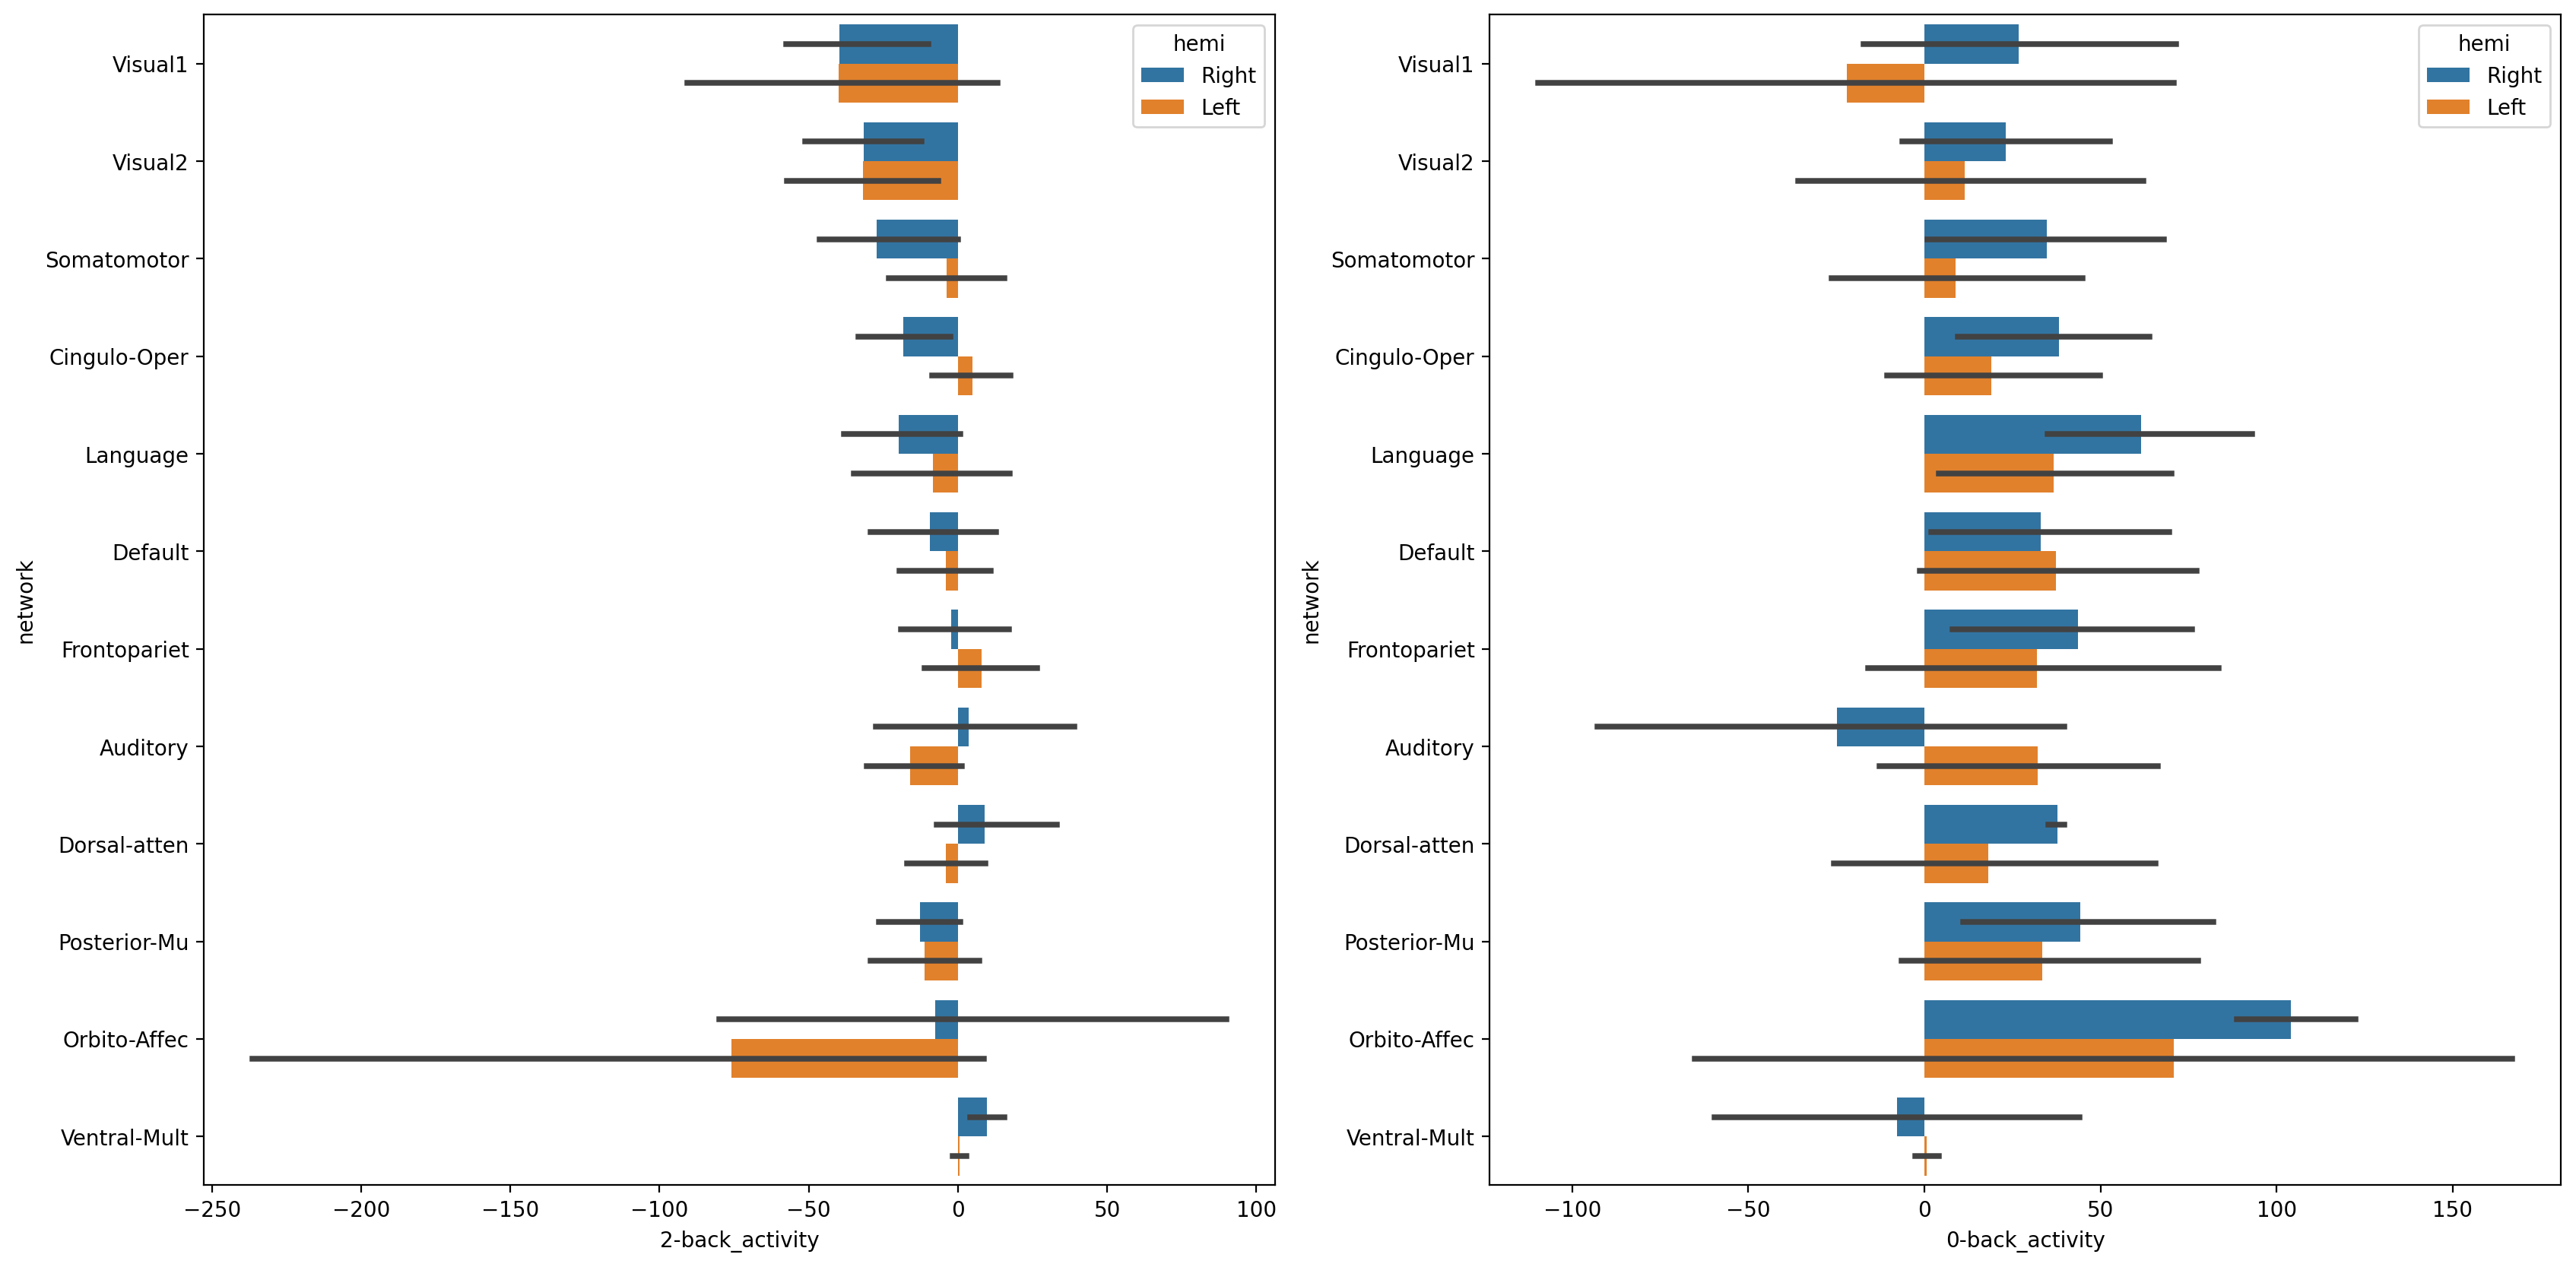

In [21]:
df = pd.DataFrame({'2-back_activity' : activity_2bk,
                   '0-back_activity' : activity_0bk,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.barplot(y='network', x='2-back_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='0-back_activity', data=df, hue='hemi',ax=ax2)
plt.show()

### Group Analysis

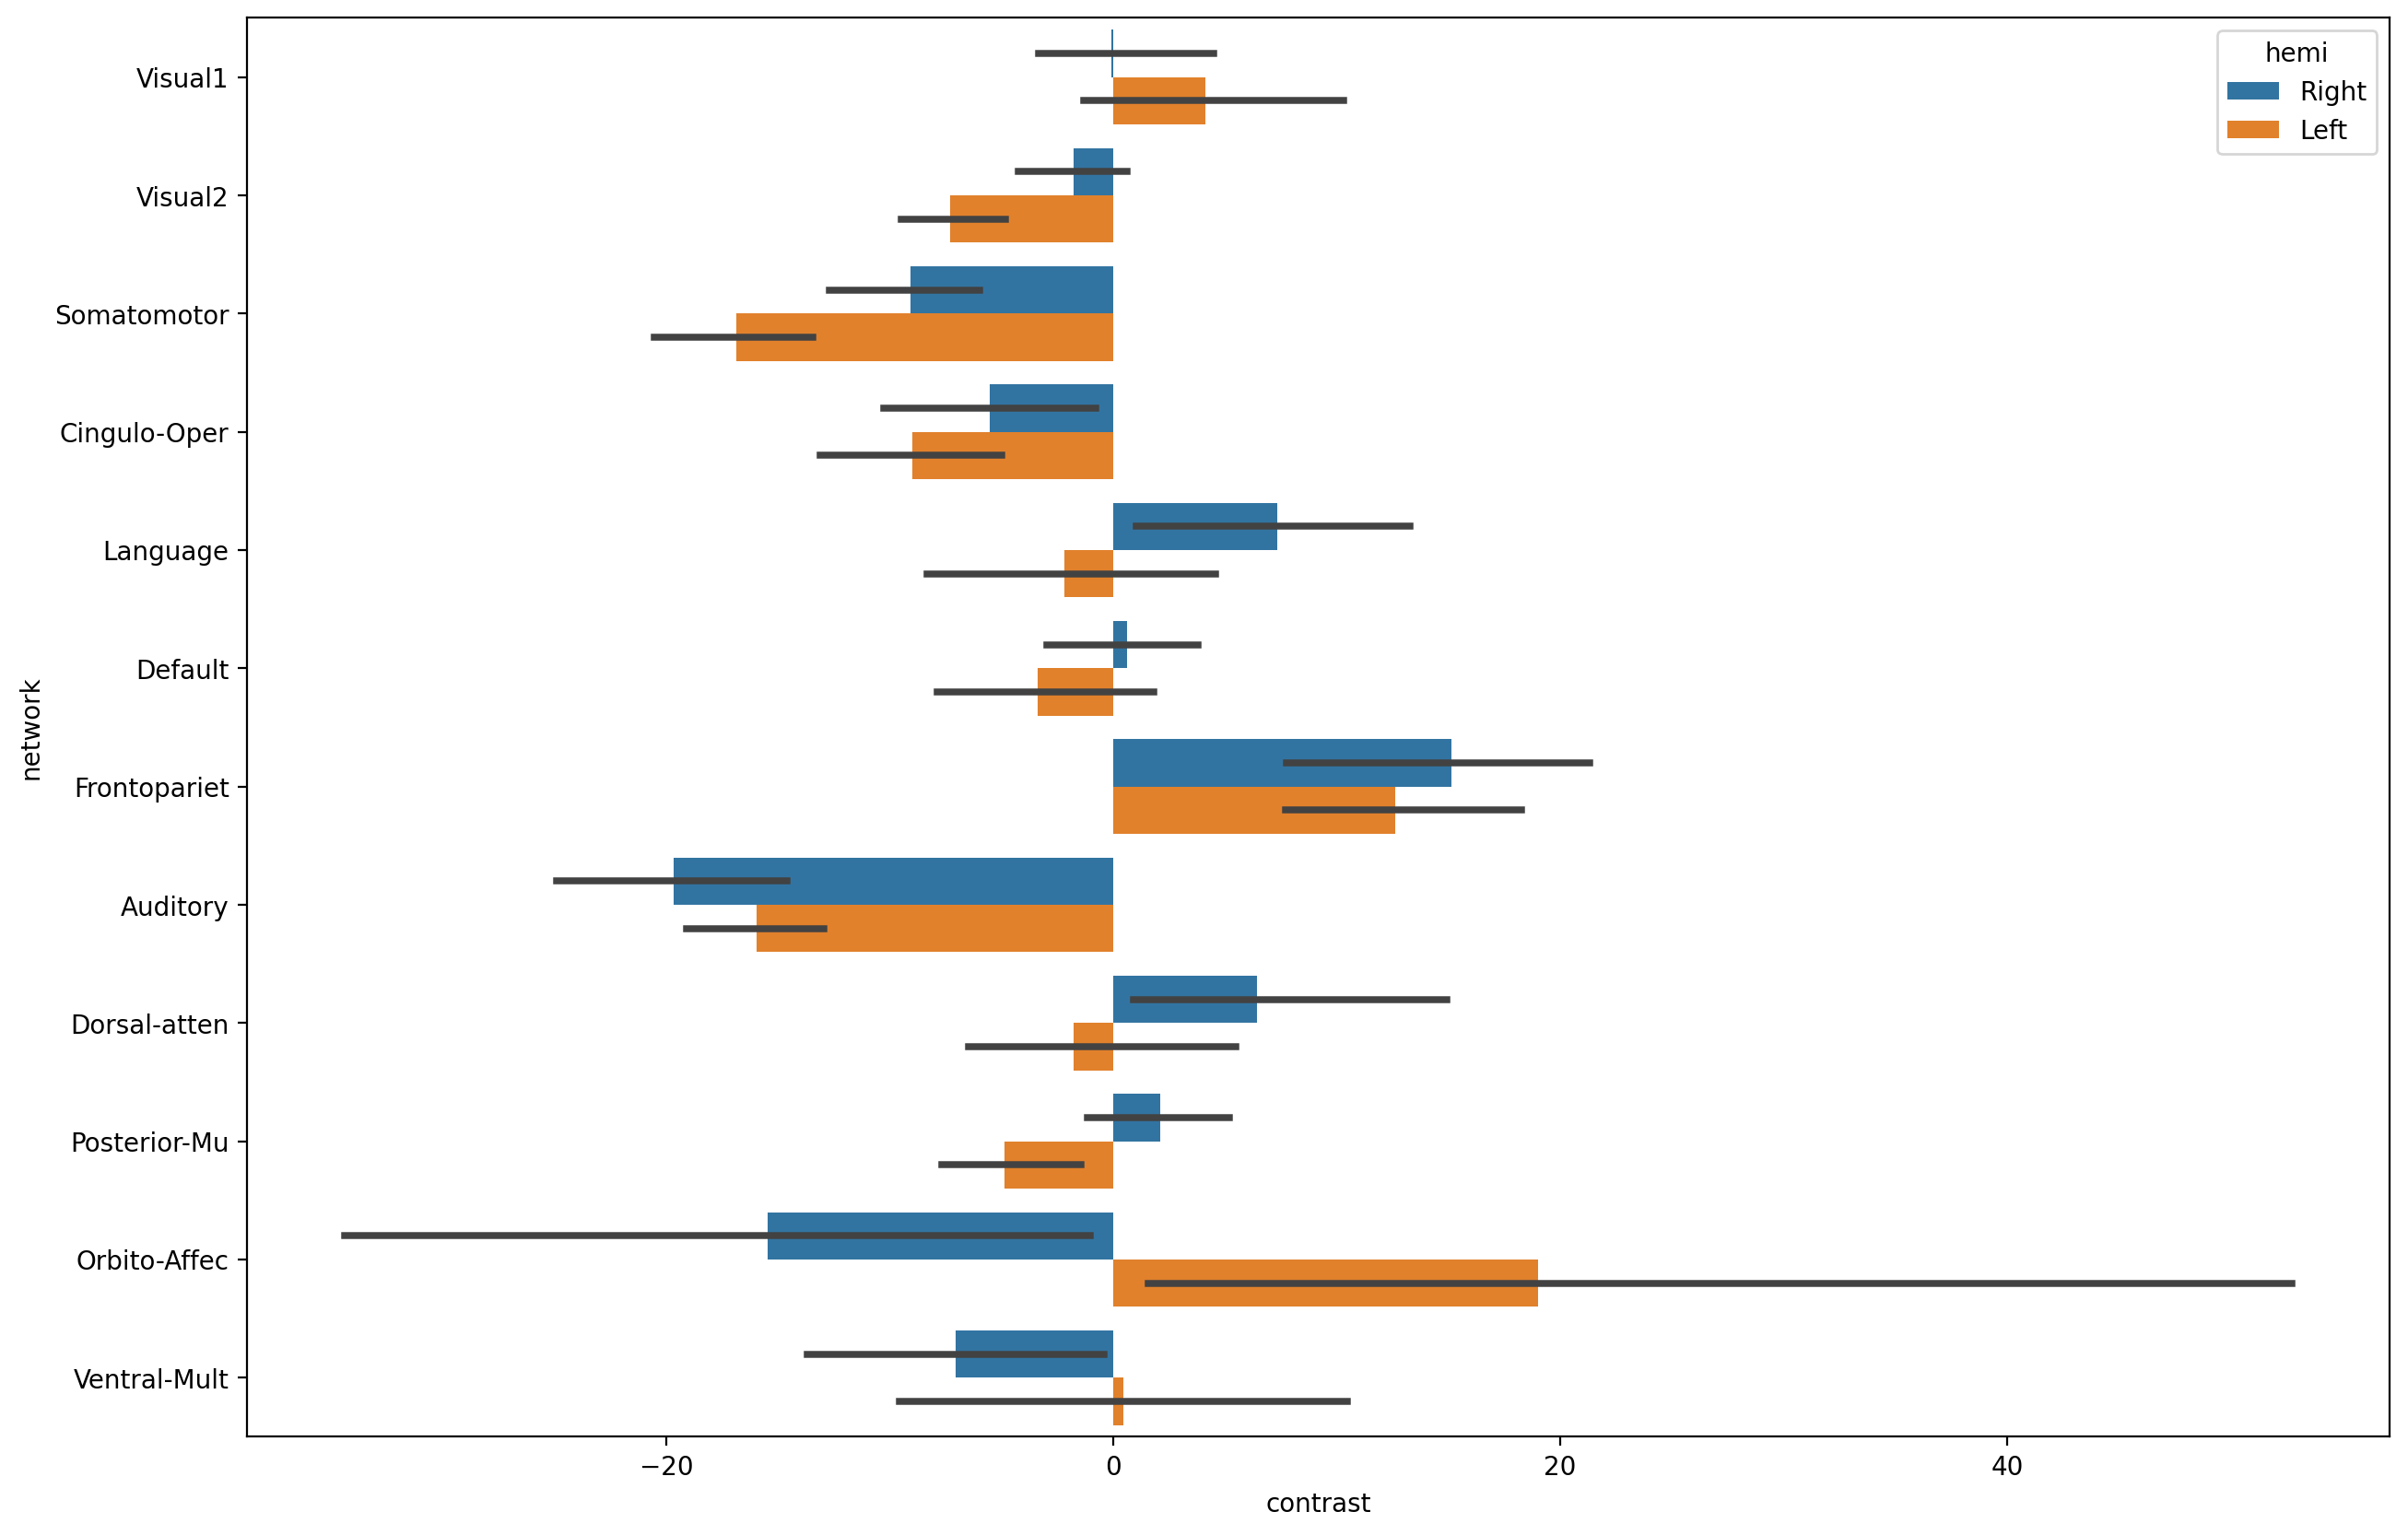

In [24]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=exp,run=r)

    activity_2bk = average_frames(data, evs, exp, '2bk_faces')
    activity_0bk = average_frames(data, evs, exp, '0bk_faces')

    contrast = activity_2bk - activity_0bk
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })

plt.figure(figsize=(15,10))
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

# DLPFC Correlations with Task-specific Regions

In [9]:
"""Define labels for areas"""
dlpfc_labels = ["8C", "8Av", "i6-8", "s6-8", "SFL", "8BL", "9p", "9a", "8Ad", "p9-46v", "a9-46v", "46", "9-46d"]
pfc_labels = ['R_'+i for i in dlpfc_labels]
pfc_labels += ['L_'+i for i in dlpfc_labels]
# Note that these regions are present in the separately for right and left
# So use R_ or L_ before these to get the necessary data
FFC_labels = ['R_FFC', 'L_FFC']
body_labels = ['R_VVC', 'L_VVC']
para_labels=["PHA3","STSda","V4t"]
ppa_labels = ['R_'+i for i in para_labels]
ppa_labels += ['L_'+i for i in para_labels]
loc_labels=['R_VMV2','L_VMV2']

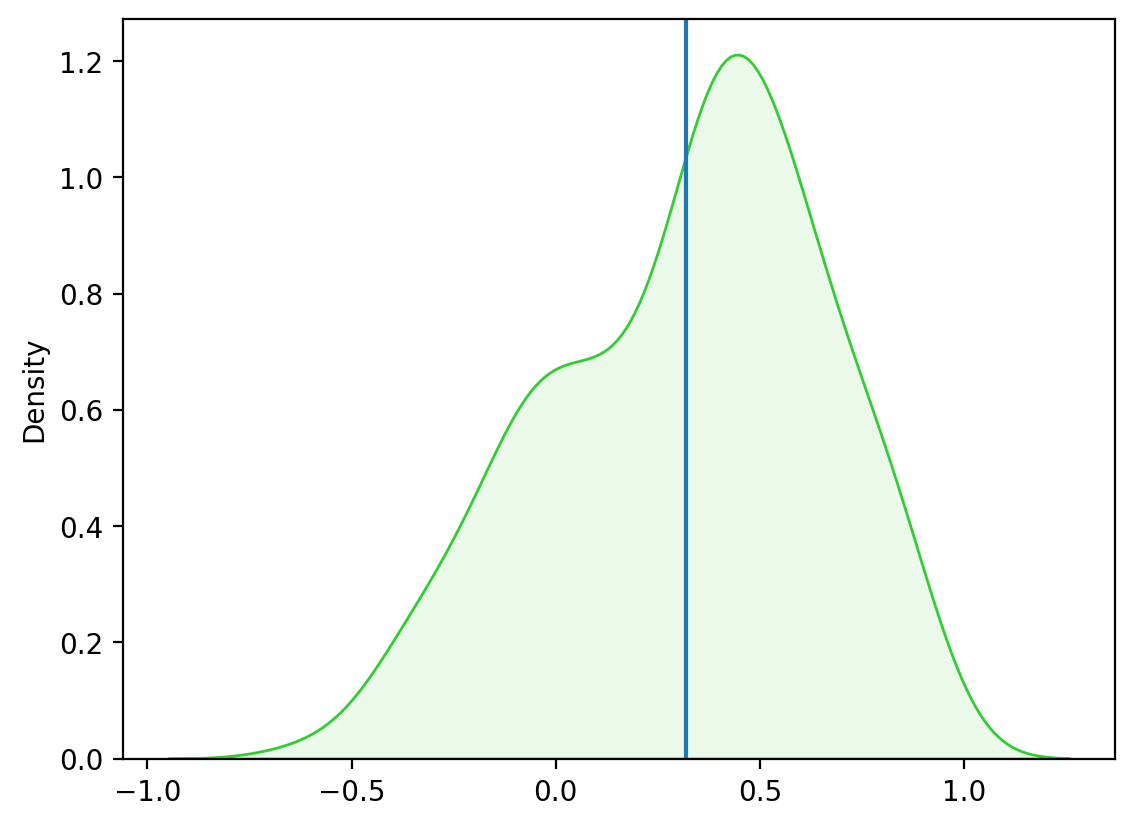

In [10]:
conds = ['2bk_faces', '0bk_faces']
remove_first_n = 12 # We remove first 8.5 seconds for introductory phase and its time lagged effect

def get_area_mean(data, areas):
  mean = []
  for area in areas:
    mean.append(get_area_data(data, area))
  return np.array(mean).mean(axis=0)

ffc_correlations = []
for s in subjects: # For all subjects
  for r in [0, 1]: # For all runs
    # Get data and event indices
    data = load_single_timeseries(subject=s, experiment=exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=exp,run=r)

    # Calculate contrast of 2bk and 0bk faces cond
    diff_ffc, diff_pfc = [], []
    for cond in conds: # For all conditions
      # FFC Area
      ffc_data = get_area_mean(data, FFC_labels) # Get data
      idx = get_ev_indices(exp, cond) # Get indices
      diff_ffc.append(get_cond_related_signal(ffc_data, evs, idx)[0][0][remove_first_n:]) # Get area cond data
      # PFC Area
      pfc_data = get_area_mean(data, pfc_labels) # Get data
      # Already gotten indices, use idx
      diff_pfc.append(get_cond_related_signal(pfc_data, evs, idx)[0][0][remove_first_n:]) # Get area cond data

    # Calc contrast array
    contrast_faces = diff_ffc[0] - diff_ffc[1]
    contrast_pfc = diff_pfc[0] - diff_pfc[1]
    # Calc corr
    correlation = np.corrcoef(contrast_pfc.ravel(), contrast_faces.ravel())[0, 1]
    ffc_correlations.append(correlation)

ax = sns.kdeplot(x = ffc_correlations, fill = True, color = "limegreen", alpha = 0.1)
# Plot mean line
mean = np.mean(ffc_correlations)
ax.axvline(x = mean,
           ymin = 0,
           ymax = 1)

## Distribution of Correlation Coefficients for dlPFC with Task-related Regions

Figure below is obtained by running the code above for different regions.

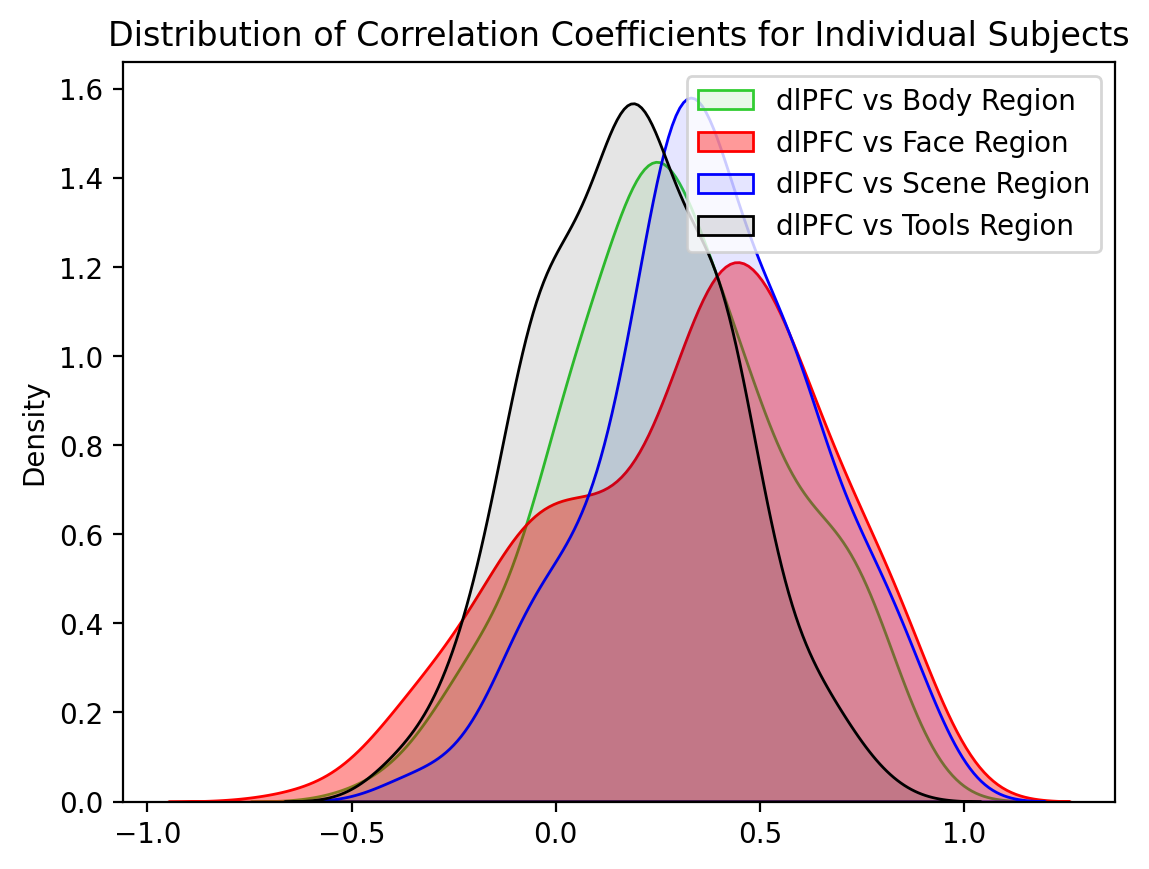

In [32]:
ax = sns.kdeplot(x = pfc_correlations, fill = True, color = "limegreen", alpha = 0.1, label = 'dlPFC vs Body Region')
sns.kdeplot(x = ffc_correlations, fill = True, color = "red", alpha = 0.4, ax=ax, label = 'dlPFC vs Face Region')
sns.kdeplot(x = ppa_correlations, fill = True, color = "blue", alpha = 0.1, ax=ax, label = 'dlPFC vs Scene Region')
sns.kdeplot(x = loc_correlations, fill = True, color = "black", alpha = 0.1, ax=ax, label = 'dlPFC vs Tools Region')
plt.title('Distribution of Correlation Coefficients for Individual Subjects')
plt.legend()
mean_ffc = np.mean(ffc_correlations)
mean_pfc = np.mean(pfc_correlations)

# Mean Signal for Areas

Text(0.5, 1.0, 'Area Mean Signals Plot for Faces Task')

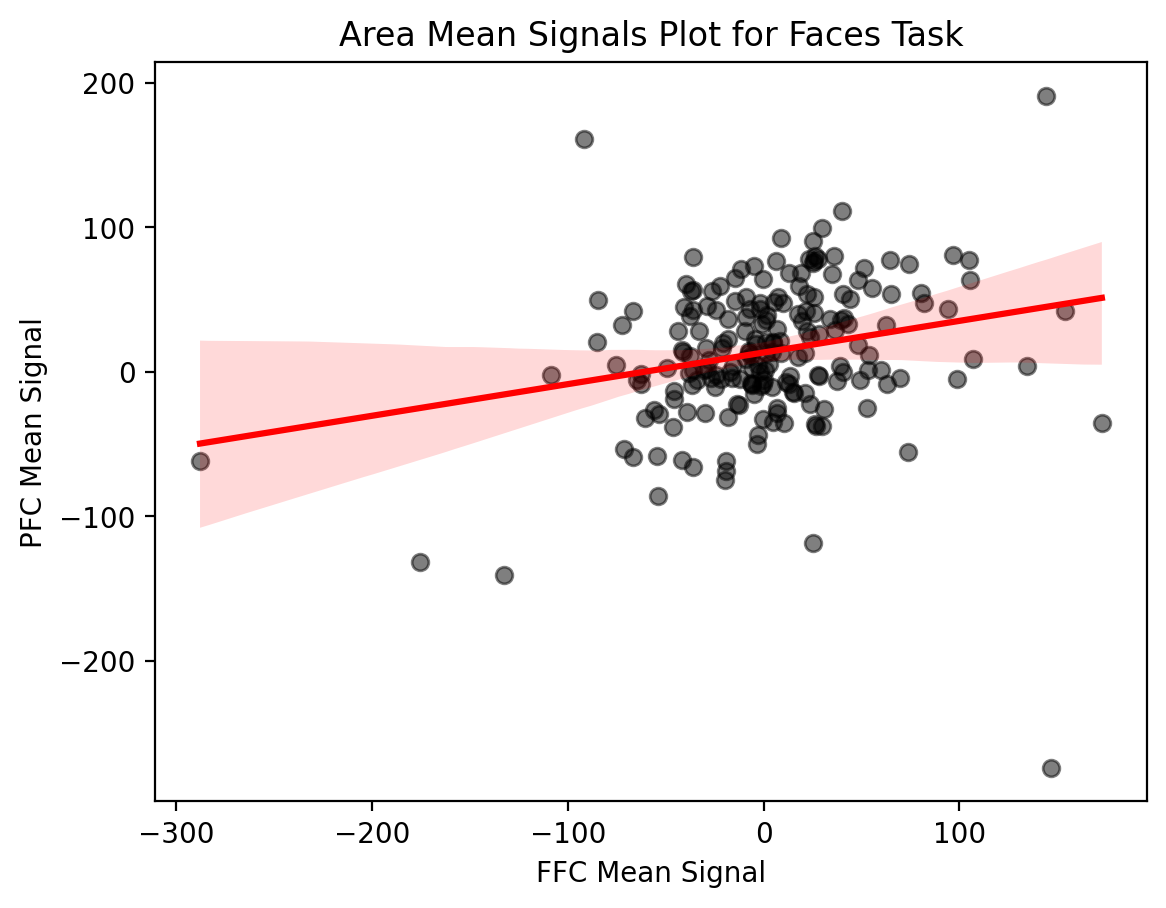

In [25]:
remove_first_n = 12
conds = ['2bk_faces', '0bk_faces']

mean_ffc, mean_pfc = [], []
for s in subjects: # For all subjects
  for r in [0, 1]: # For all runs
    # Get data and event indices
    data = load_single_timeseries(subject=s, experiment=exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=exp,run=r)

    diff_ffc, diff_pfc = [], []
    for cond in conds:
      idx = get_ev_indices(exp, cond) # Get indices

      ffc_data = get_area_mean(data, FFC_labels)
      diff_ffc.append(get_cond_related_signal(ffc_data, evs, idx)[0][0][remove_first_n:])

      pfc_data = get_area_mean(data, pfc_labels)
      diff_pfc.append(get_cond_related_signal(pfc_data, evs, idx)[0][0][remove_first_n:])

    # Calc contrast array
    contrast_faces = diff_ffc[0] - diff_ffc[1]
    contrast_pfc = diff_pfc[0] - diff_pfc[1]

    mean_ffc.append(contrast_faces.mean())
    mean_pfc.append(contrast_pfc.mean())


# Calculate the fit
coefs = np.polyfit(mean_ffc, mean_pfc, 1) # Change the integer for other orders
p = np.poly1d(coefs)
y_fitted = p(mean_ffc)
#plt.plot(mean_ffc, y_fitted, 'b')

sns.regplot(x = mean_ffc, y = mean_pfc,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})
plt.ylabel('PFC Mean Signal')
plt.xlabel('FFC Mean Signal')
plt.title('Area Mean Signals Plot for Faces Task')

# GLM

In [27]:
# dlPFCregion = betaFace * FFC + betaBody * BodyRegion + betaScene * SceneRegion + betaTool * ToolRegion + const

import statsmodels.api as sm

def get_area_data(data, area):
  area_idx = np.where(regions[0] == area)[0] # Get area indices
  return data[area_idx, :] # Get that area from the data and return

def get_ev_indices(exp, cond):
  """Returns the condition indices relating to fMRI data"""
  return EXPERIMENTS[exp]['cond'].index(cond)

def get_cond_related_signal(data, evs, idx):
  return data[:, evs[idx]]

def get_area_mean(data, areas):
  mean = []
  for area in areas:
    mean.append(get_area_data(data, area))
  return np.array(mean).mean(axis=0)

exp = 'WM'
conds = ['2bk_faces', '0bk_faces']
remove_first_n = 12

face_means = []
body_means = []
ppa_means = []
loc_means = []
pfc_means = []

face_means_runs, body_means_runs, ppa_means_runs, loc_means_runs, pfc_means_runs = [], [], [], [], []
for s in subjects: # For all subjects
  for r in [0, 1]: # For all runs
    # Get data and event indices
    data = load_single_timeseries(subject=s, experiment=exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=exp,run=r)

    diff_face, diff_body, diff_ppa, diff_loc, diff_pfc = [],[],[],[],[]
    for cond in conds: # For all conditions
      idx = get_ev_indices(exp, cond) # Get indices

      ffc_data = get_area_mean(data, FFC_labels)
      diff_face.append(get_cond_related_signal(ffc_data, evs, idx)[0][0][remove_first_n:])
      body_data = get_area_mean(data, body_labels)
      diff_body.append(get_cond_related_signal(body_data, evs, idx)[0][0][remove_first_n:])
      ppa_data = get_area_mean(data, ppa_labels)
      diff_ppa.append(get_cond_related_signal(ppa_data, evs, idx)[0][0][remove_first_n:])
      loc_data = get_area_mean(data, loc_labels)
      diff_loc.append(get_cond_related_signal(loc_data, evs, idx)[0][0][remove_first_n:])
      pfc_data = get_area_mean(data, pfc_labels)
      diff_pfc.append(get_cond_related_signal(pfc_data, evs, idx)[0][0][remove_first_n:])

    face_cont = diff_face[0] - diff_face[1]
    body_cont = diff_body[0] - diff_body[1]
    ppa_cont = diff_ppa[0] - diff_ppa[1]
    loc_cont = diff_loc[0] - diff_loc[1]
    pfc_cont = diff_pfc[0] - diff_pfc[1]

    face_mean = np.mean(face_cont)
    body_mean = np.mean(body_cont)
    ppa_mean = np.mean(ppa_cont)
    loc_mean = np.mean(loc_cont)
    pfc_mean = np.mean(pfc_cont)

    face_means_runs.append(face_mean)
    body_means_runs.append(body_mean)
    ppa_means_runs.append(ppa_mean)
    loc_means_runs.append(loc_mean)
    pfc_means_runs.append(pfc_mean)

  face_means.append(np.mean(face_means_runs))
  body_means.append(np.mean(body_means_runs))
  ppa_means.append(np.mean(ppa_means_runs))
  loc_means.append(np.mean(loc_means_runs))
  pfc_means.append(np.mean(pfc_means_runs))

  face_means_runs, body_means_runs, ppa_means_runs, loc_means_runs, pfc_means_runs = [], [], [], [], []

predictors = pd.DataFrame({
    'Face': face_means,
    'Body': body_means,
    'Scene': ppa_means,
    'Tools': loc_means
})

predictors = sm.add_constant(predictors)
model = sm.GLM(pfc_means, predictors)

results = model.fit()

In [28]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       95
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          961.74
Method:                          IRLS   Log-Likelihood:                -482.77
Date:                Sat, 29 Jul 2023   Deviance:                       91365.
Time:                        00:16:42   Pearson chi2:                 9.14e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1453
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6844      3.958      4.721      0.000      10.927      26.442
Face           0.0863      0.132      0.653      0.514      -0.173       0.345
Body           0.0337      0.109      0.309      0.757      -0.180       0.247
Scene          0.4064      0.201      2.026      0.043       0.013       0.800
Tools         -0.0044      0.066     -0.066      0.947      -0.134       0.125
==============================================================================
"""